# MachineMax Technical Test - Model Building

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, accuracy_score, auc, classification_report
from xgboost import XGBClassifier
from Codebase.models import TimeSeriesModelEvaluator
from Codebase.statistical_models import LinearRegressionPredictor

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Loading Data

In [2]:
df = pd.read_csv('./data/time-series1.csv')

## Preprocessing Data

In [3]:
# Convert the timestamp to a numerical value
df['timestamp_asint'] = pd.to_datetime(df['timestamp']).astype('int64')

df.head()

,rms,state,timestamp,timestamp_asint
0,0.236160,States.OFF,2021-01-01 00:00:00,1609459200000000000
1,1.485381,States.OFF,2021-01-01 00:00:10,1609459210000000000
2,1.128444,States.OFF,2021-01-01 00:00:20,1609459220000000000
3,1.190676,States.OFF,2021-01-01 00:00:30,1609459230000000000
4,1.441717,States.OFF,2021-01-01 00:00:40,1609459240000000000


In [4]:
# Encode the categorical state variable using one-hot encoding
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(df[['state']])
df[['States.ACTIVE', 'States.IDLE', 'States.OFF']] = y_encoded.toarray().astype(int)
df['state_encoded'] = np.argmax(y_encoded, axis=1)

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
df[['timestamp_scaled', 'rms_scaled']] = scaler.fit_transform(df[['timestamp_asint', 'rms']])

In [6]:
df.columns = df.columns.map(str)
df.head(200)

,rms,state,timestamp,timestamp_asint,States.ACTIVE,States.IDLE,States.OFF,state_encoded,timestamp_scaled,rms_scaled
0,0.236160,States.OFF,2021-01-01 00:00:00,1609459200000000000,0,0,1,2,0.000000,0.000263
1,1.485381,States.OFF,2021-01-01 00:00:10,1609459210000000000,0,0,1,2,0.001346,0.001721
2,1.128444,States.OFF,2021-01-01 00:00:20,1609459220000000000,0,0,1,2,0.002692,0.001304
3,1.190676,States.OFF,2021-01-01 00:00:30,1609459230000000000,0,0,1,2,0.004038,0.001377
4,1.441717,States.OFF,2021-01-01 00:00:40,1609459240000000000,0,0,1,2,0.005384,0.001670
...,...,...,...,...,...,...,...,...,...,...
195,506.705862,States.ACTIVE,2021-01-01 00:32:30,1609461150000000000,1,0,0,0,0.262450,0.591398
196,466.630940,States.ACTIVE,2021-01-01 00:32:40,1609461160000000000,1,0,0,0,0.263795,0.544624
197,547.582753,States.ACTIVE,2021-01-01 00:32:50,1609461170000000000,1,0,0,0,0.265141,0.639108
198,587.969861,States.ACTIVE,2021-01-01 00:33:00,1609461180000000000,1,0,0,0,0.266487,0.686247


# Model Building

## Metrics Used:
- **Accuracy**: The proportion of true results (both true positives and true negatives) among the total number of cases examined. It measures the overall performance of the model.

- **Precision**: The proportion of true positives among the total number of positive results (true positives and false positives). It measures the ability of the model to correctly identify positive cases.

- **Recall**: The proportion of true positives among the total number of actual positive cases (true positives and false negatives). It measures the ability of the model to correctly identify all positive cases.

- **F1 score**: The harmonic mean of precision and recall. It provides a single score that balances both precision and recall.

- **Confusion matrix**: A table that summarizes the performance of a classification model by comparing predicted and actual values. It shows the number of true positives, false positives, true negatives, and false negatives.

## Statistical Models

### Rolling Window Slope Estimation - Linear Regression
This code calculates the slope of the 'rms' column of the dataframe using a rolling window of size 10. It then creates a new column 'engine_state' based on the slope value. If the slope is positive, the engine state is set to 0 (ACTIVE), otherwise it is set to 1 (IDLE). Additionally, if the 'rms' value is less than 2, the engine state is set to 2 (which represents 'OFF'). The function `calculate_slope` uses linear regression to calculate the slope of the series.

**Limitations**:

1. **Simplicity**: The model is quite simple and might not capture complex relationships between variables. For instance, it does not consider interactions between features or non-linear relationships.

2. **Linear Assumption**: The model assumes a linear relationship between time and feature values when calculating the slopes using linear regression, which may not always hold true.

3. **Arbitrary Thresholds**: Predictions are partially based on fixed thresholds (e.g., engine state changing when 'rms' is less than 2). These thresholds might not generalize well to different scenarios or datasets.

4. **Non-Adaptive**: The model doesn't learn or adapt over time as it receives more data. Unlike machine learning models, it cannot improve its predictions as more information becomes available.

5. **Lack of Robustness**: The model could be sensitive to outliers or noise in the data. A single outlier value can significantly affect the slope calculated for a rolling window.

6. **Assumes Stationarity**: The model implicitly assumes that the underlying data-generating process doesn't change over time. If there are trends, seasonality, or other non-stationary elements in the data, the model's performance might suffer.

7. **Class Imbalance**: If the target variable 'state_encoded' is imbalanced, some of the metrics may not provide a true picture of the model's performance. For example, accuracy can be misleadingly high when the model predominantly predicts the majority class.

Not considering sequence: The model fails to account for the sequence of the states. In many cases, including past states or a sequence of readings as part of the input data could improve prediction accuracy.

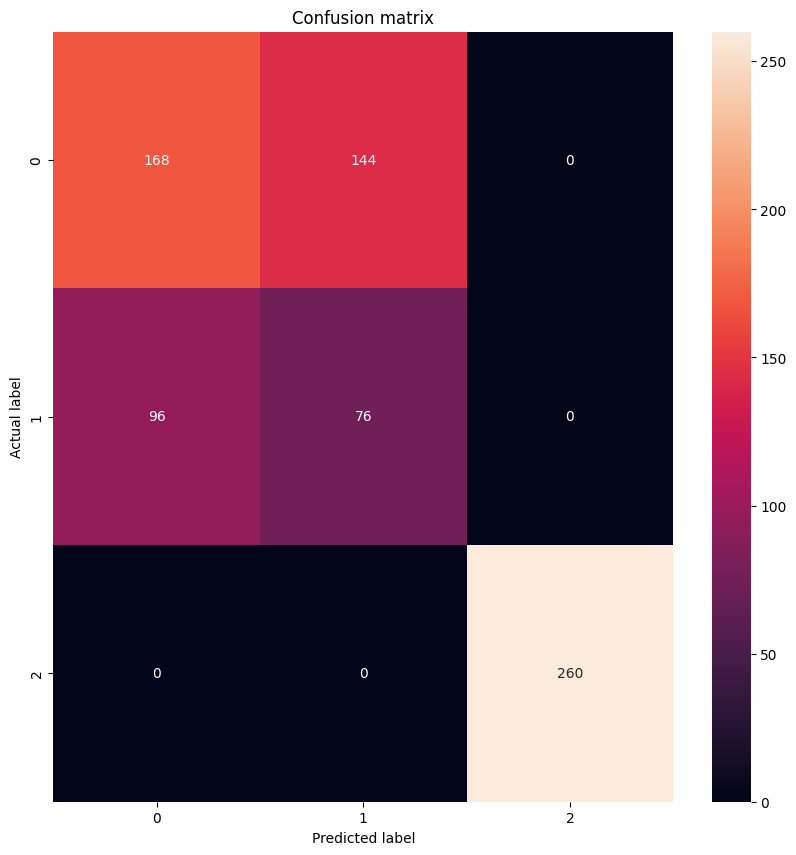

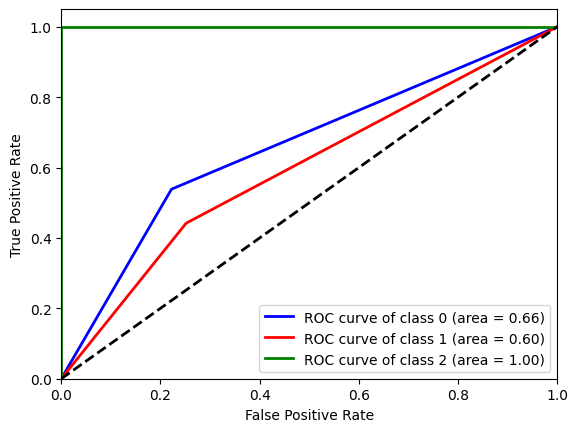

accuracy: 
0.6774193548387096
precision: 
0.6606060606060606
recall: 
0.6601073345259392
f1_score: 
0.6570294784580498
confusion_matrix: 
[[168 144   0]
 [ 96  76   0]
 [  0   0 260]]
classification_report: 
              precision    recall  f1-score   support

           0       0.64      0.54      0.58       312
           1       0.35      0.44      0.39       172
           2       1.00      1.00      1.00       260

    accuracy                           0.68       744
   macro avg       0.66      0.66      0.66       744
weighted avg       0.70      0.68      0.68       744

roc_auc: 
{0: 0.6581196581196581, 1: 0.5950561066840135, 2: 1.0}
average_roc_auc: 
0.7510585882678905


In [7]:
linear_regression = LinearRegression()
linear_regression_predictor = LinearRegressionPredictor(linear_regression)

df['engine_state'], metrics = linear_regression_predictor.predict(df)
for key, value in metrics.items():
    print(f'{key}: \n{value}')

In [8]:
from statsmodels.tsa.stattools import adfuller
# Perform Augmented Dickey-Fuller test:
print('Results of Augmented Dickey-Fuller Test:')
dftest = adfuller(df['rms'], autolag='AIC')  # change 'vibration' to your column name

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -1.959854
p-value                          0.304448
#Lags Used                       6.000000
Number of Observations Used    737.000000
Critical Value (1%)             -3.439254
Critical Value (5%)             -2.865470
Critical Value (10%)            -2.568863
dtype: float64


## Machine-Learning Models
Data will be split using TimeSeriesSplit or train_test_split (taking the last 25% as the test data
)
### Logistic Regression

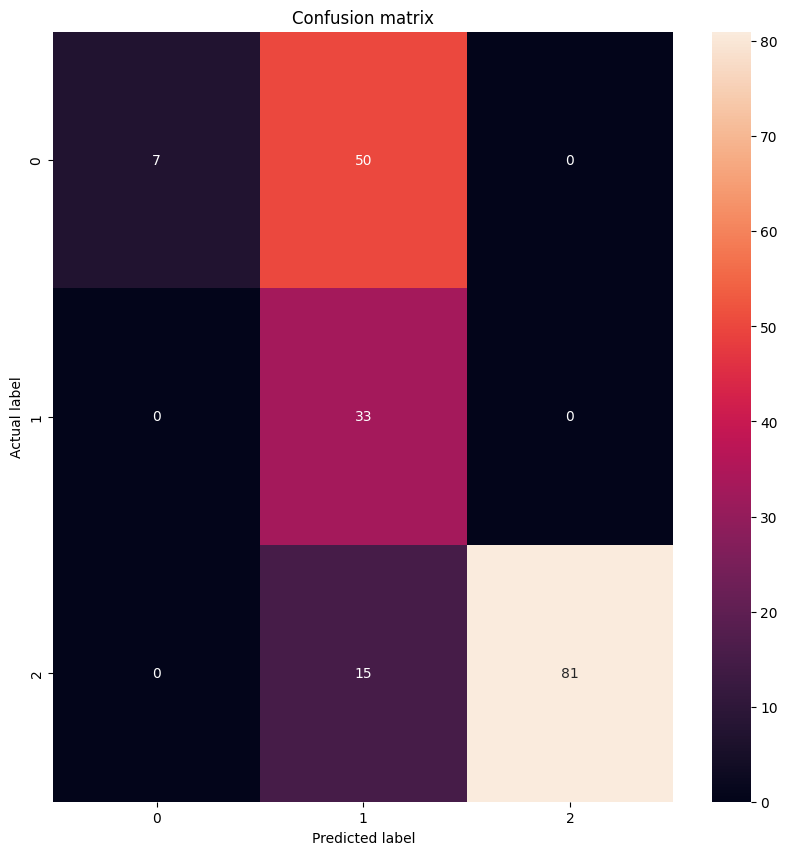

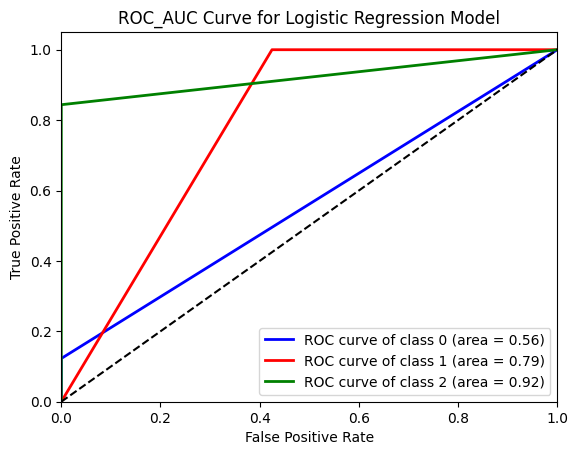

In [9]:
# Train a logistic regression model
model = LogisticRegression()

evaluator = TimeSeriesModelEvaluator(model)

LR_metrics = evaluator.evaluate(
    X=df[['timestamp_scaled', 'rms_scaled']].values,
    y=df['state_encoded'].values
)

In [10]:
# print the metrics
for key, value in LR_metrics.items():
    print(f"{key}: \n{value}")

accuracy: 
0.6505376344086021
precision: 
0.7789115646258503
recall: 
0.6555190058479532
f1_score: 
0.5459403437270884
confusion_matrix: 
[[ 7 50  0]
 [ 0 33  0]
 [ 0 15 81]]
classification_report: 
              precision    recall  f1-score   support

           0       1.00      0.12      0.22        57
           1       0.34      1.00      0.50        33
           2       1.00      0.84      0.92        96

    accuracy                           0.65       186
   macro avg       0.78      0.66      0.55       186
weighted avg       0.88      0.65      0.63       186

roc_auc: 
{0: 0.5614035087719298, 1: 0.7875816993464052, 2: 0.921875}
average_roc_auc: 
0.7569534027061117


### Random Forest

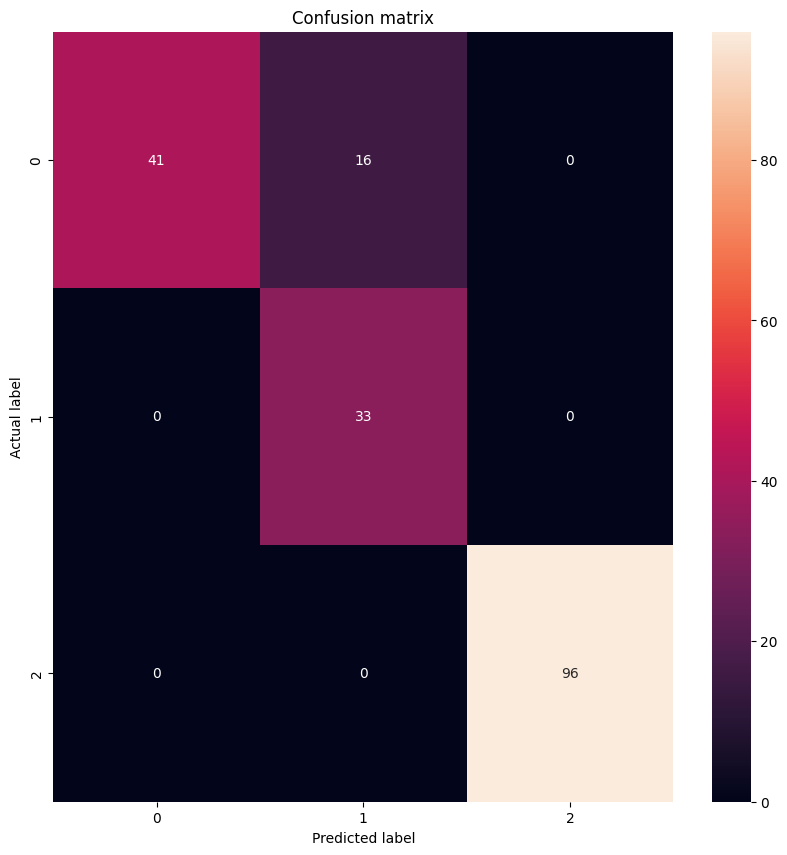

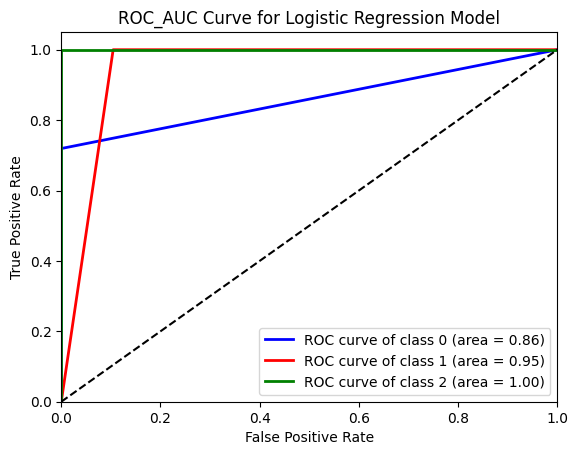

Best hyperparameters: {'n_estimators': 1200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}


In [12]:
rf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': [False]
}

evaluator = TimeSeriesModelEvaluator(rf, random_grid)

RF_metrics = evaluator.evaluate(
    X=df[['timestamp_scaled', 'rms_scaled']].values,
    y=df['state_encoded'].values
)

In [13]:
# print the metrics
for key, value in RF_metrics.items():
    print(f"{key}: \n{value}\n")

accuracy: 
0.9139784946236559

precision: 
0.891156462585034

recall: 
0.9064327485380117

f1_score: 
0.880537580886013

confusion_matrix: 
[[41 16  0]
 [ 0 33  0]
 [ 0  0 96]]

classification_report: 
              precision    recall  f1-score   support

           0       1.00      0.72      0.84        57
           1       0.67      1.00      0.80        33
           2       1.00      1.00      1.00        96

    accuracy                           0.91       186
   macro avg       0.89      0.91      0.88       186
weighted avg       0.94      0.91      0.92       186


roc_auc: 
{0: 0.8596491228070176, 1: 0.9477124183006537, 2: 1.0}

average_roc_auc: 
0.9357871803692238



### XGBoost

**ADD EXPLANATION OF XGBOOST HERE**

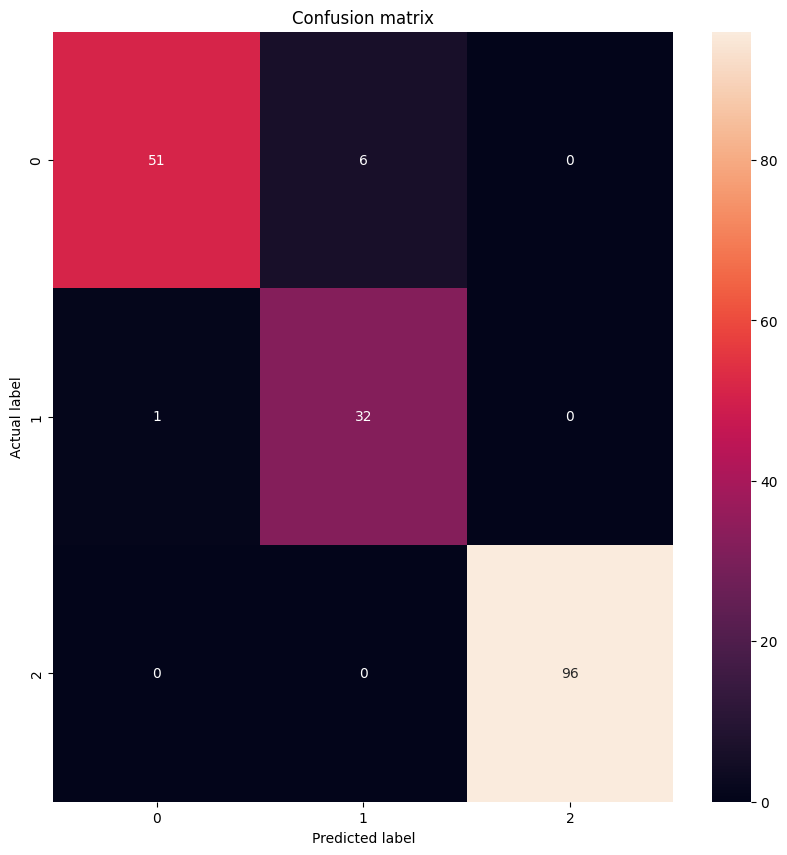

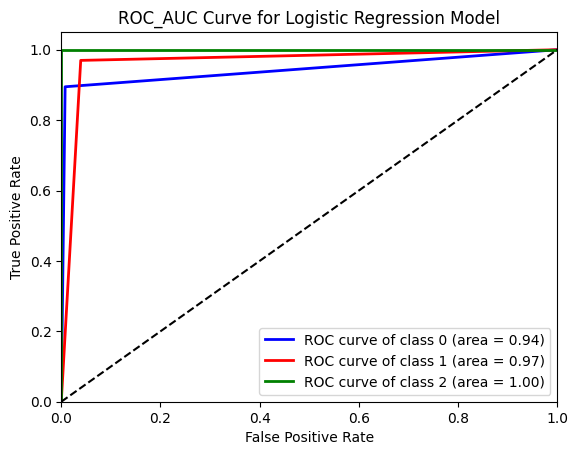

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [34]:
# Instantiate XGBoost classifier
xgb_model = XGBClassifier()

# Hyperparameters for XGBoost
hyperparams = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3], # This parameter controls the step size shrinkage, which is used to prevent overfitting.
    'max_depth': [3, 4, 5, 6], # This parameter controls the maximum depth of each tree.
    'n_estimators': [50, 100, 200] # This parameter controls the number of estimators or trees in the model.
}

# Instantiate the evaluator with the XGBoost classifier
evaluator = TimeSeriesModelEvaluator(xgb_model, hyperparams)

# Use your dataframe's feature and target columns as X and y
X = df[['timestamp_scaled', 'rms_scaled']].values
y = df['state_encoded'].values

# Evaluate the model
xg_metrics = evaluator.evaluate(X, y)

In [13]:
# print the metrics
for key, value in xg_metrics.items():
    print(f"{key}: \n{value}\n")

accuracy: 
0.9623655913978495

precision: 
0.9409581646423751

recall: 
0.9548112706007443

f1_score: 
0.9457294224059956

confusion_matrix: 
[[51  6  0]
 [ 1 32  0]
 [ 0  0 96]]

classification_report: 
              precision    recall  f1-score   support

           0       0.98      0.89      0.94        57
           1       0.84      0.97      0.90        33
           2       1.00      1.00      1.00        96

    accuracy                           0.96       186
   macro avg       0.94      0.95      0.95       186
weighted avg       0.97      0.96      0.96       186


roc_auc: 
{0: 0.9434924520603836, 1: 0.9652406417112299, 2: 1.0}

average_roc_auc: 
0.9695776979238712



## Time-Segment Identification

### Change-Point Detection

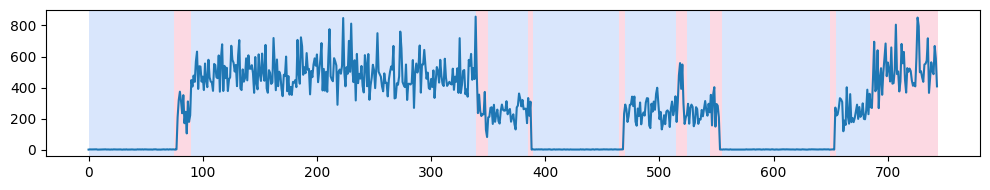

In [20]:
# Assuming you have preprocessed and smoothed time-series data stored in 'data'
timestamps = df['timestamp']
rms_values = df['rms']

# Convert the data into a numpy array
series = np.array(rms_values)

# Define the change-point detection model using the PELT algorithm
model = "normal"  # can be "l2", "rbf", "linear", "normal", etc.
algo = rpt.Pelt(model=model).fit(series)

# Perform change-point detection
result = algo.predict(pen=10)  # Adjust the pen parameter to control the sensitivity

# Plot the results
rpt.display(series, result)
plt.show()